A counterfactual explanation describes a causal situation in the form: “If X had not occurred, Y would not have occurred”. For example: “If I hadn’t taken a sip of this hot coffee, I wouldn’t have burned my tongue”. Event Y is that I burned my tongue; Cause X for this event is that I had a hot coffee. Thinking in counterfactuals requires imagining a hypothetical reality that contradicts the observed facts (e.g. a world in which I have not drunk the hot coffee), hence the name “counterfactual”. The ability to think counterfactual makes us humans so smart compared to other animals.

In interpretable machine learning, counterfactual explanations can be used to explain predictions of individual instances. The “event” is the predicted outcome of an instance, the “causes” are the particular feature values of this instance that were input to the model and “caused” a certain prediction. Displayed as a graph, the relationship between the inputs and the prediction is very simple: The feature values cause the prediction.

The counterfactual explanation method is model-agnostic, since it only works with the model inputs and output.

In this first example, Peter applies for a loan and gets rejected by the (machine learning powered) banking software. He wonders why his application was rejected and how he might improve his chances to get a loan. The question of “why” can be formulated as a counterfactual: What is the smallest change to the features (income, number of credit cards, age, …) that would change the prediction from rejected to approved? One possible answer could be: If Peter would earn 10,000 Euro more per year, he would get the loan. Or if Peter had fewer credit cards and hadn’t defaulted on a loan 5 years ago, he would get the loan. Peter will never know the reasons for the rejection, as the bank has no interest in transparency, but that’s another story

Speaking of criteria, how do we define a good counterfactual explanation? First, the user of a counterfactual explanation defines a relevant change in the prediction of an instance (= the alternative reality), so an obvious first requirement is that a counterfactual instance produces the predefined prediction as closely as possible. It is not always possible to match the predefined output exactly. In a classification setting with two classes, a rare class and a common class, the model could always classify an instance as the common class. Changing the feature values so that the predicted label would flip from the common class to the rare class might be impossible. We therefore want to relax the requirement that the predicted output of the counterfactual must correspond exactly to the defined outcome. In the classification example, we could look for a counterfactual where the predicted probability of the rare class is increased to 10% instead of the current 2%. The question then is, what are the minimum changes to the features so that the predicted probability changes from 2% to 10% (or close to 10%)? Another quality criterion is that a counterfactual should be as similar as possible to the instance regarding feature values. This requires a distance measure between two instances. The counterfactual should not only be close to the original instance, but should also change as few features as possible. This can be achieved by selecting an appropriate distance measure like the Manhattan distance. The last requirement is that a counterfactual instance should have feature values that are likely. It wouldn’t make sense to generate a counterfactual explanation for the rent example where the size of an apartment is negative or the number of rooms is set to 200. It is even better when the counterfactual is likely according to the joint distribution of the data, e.g. an apartment with 10 rooms and 20 square meters should not be regarded as counterfactual explanation.

Hence 
1. Allow for constraints on feature values
2. Allow for relaxation in the output

In this section, I will present the approach suggested by Wachter et. al 201741. They suggest minimizing the following loss.

L
(
x
,
x
′
,
y
′
,
λ
)
=
λ
⋅
(
^
f
(
x
′
)
−
y
′
)
2
+
d
(
x
,
x
′
)
 

The first term is the quadratic distance between the model prediction for the counterfactual x’ and the desired outcome y’, which the user must define in advance. The second term is the distance d between the instance x to be explained and the counterfactual x’, but more about this later. The parameter  
λ
  balances the distance in prediction (first term) against the distance in feature values (second term). The loss is solved for a given  
λ
  and returns a counterfactual x’. A higher value of  
λ
 means that we prefer counterfactuals that come close to the desired outcome y’, a lower value means that we prefer counterfactuals x’ that are very similar to x in the feature values. If  
λ
  is very large, the instance with the prediction that comes closest to y’ will be selected, regardless how far it is away from x. Ultimately, the user must decide how to balance the requirement that the prediction for the counterfactual matches the desired outcome with the requirement that the counterfactual is similar to x.

In [14]:
import numpy as np
from scipy.spatial.distance import cityblock

In [4]:
from scipy.optimize import minimize

In [19]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X_iris = iris.data[:, :]
y_iris = iris.target

In [12]:
boston = datasets.load_boston()
X_boston = boston.data[:, :]
y_boston = boston.target

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_iris,y_iris,test_size=0.20)
classifier = KNeighborsClassifier(n_neighbors=8)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')

In [46]:
mad = median_abs_deviation(X_iris)
print(X_iris.shape)
print(len(means))
dist = weighted_manhattan_distance(X_iris[1,:],X_iris[2,:], mad)
print(dist)

(150, 4)
4
1.0323809523809535


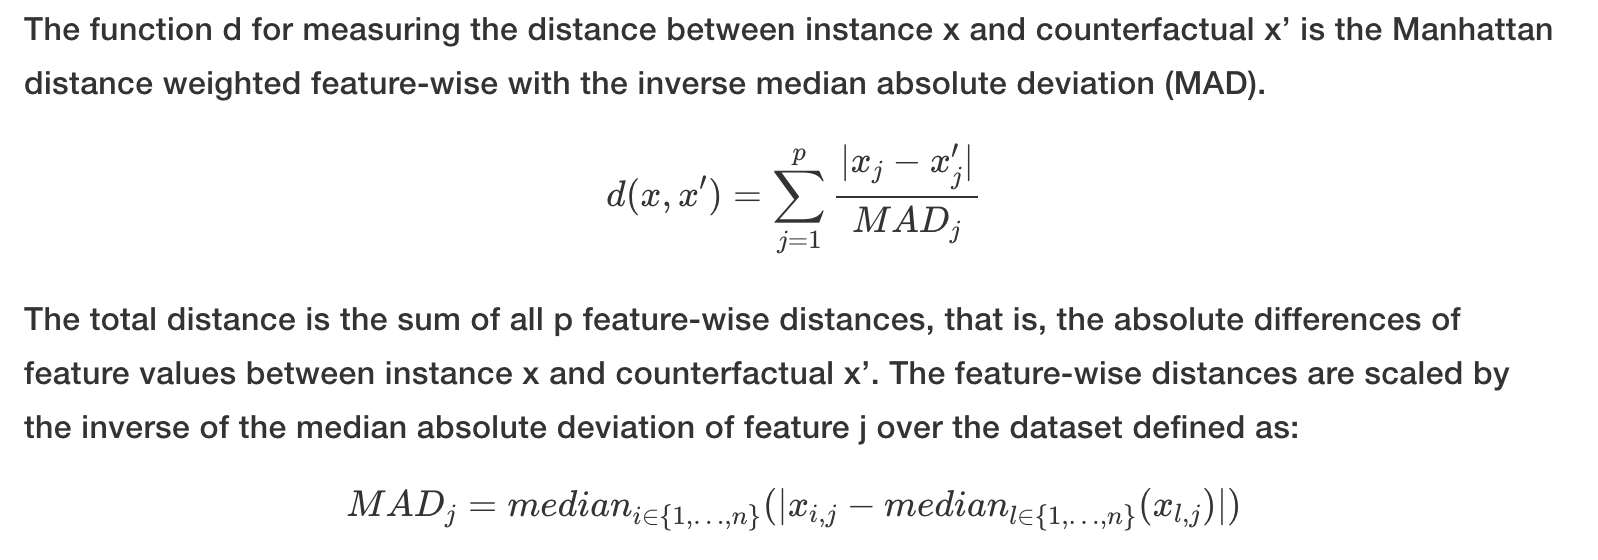

In [44]:
def median_abs_deviation(X):
    feature_medians = np.apply_along_axis(np.median, axis=0, arr=X)
    deviation_medians = []
    for i in range(len(feature_medians)):
        deviations = []
        for x in X:
            deviations.append(abs(x[i] - feature_medians[i]))
#         print(deviations)
        deviation_medians.append(np.median(deviations))
#     print(deviation_medians)
        
    return deviation_medians

#x_cf = counterfactual x
def weighted_manhattan_distance(x,x_cf,mad):
    weighted_man_dist = []
    for i in range(len(mad)):
        weighted_man_dist.append(abs(x[i]-x_cf[i])/mad[i])
    return sum(weighted_man_dist)
    

#### Take the median of the feature over all instances
#### Subtract it from the current instance's feature
#### Then take the median of this over all instances and normalize the difference with it

In [70]:
def func(x,x_actual,classifier,mad):
    #hardcoding the value of lambda for now
    return ((classifier.predict(np.reshape(x,(1, -1))) - 1)**2) + weighted_manhattan_distance(x_actual,x,mad)
x0 = [1.,1.,1.,1.]
x_actual = X_train[1,:]
res = minimize(func, x0,args=(x_actual,classifier,mad), method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 2.854610
         Iterations: 444
         Function evaluations: 772


In [71]:
print(res)

 final_simplex: (array([[5.66373909, 2.2       , 4.5       , 0.03803425],
       [5.66373909, 2.2       , 4.5       , 0.03803425],
       [5.66373908, 2.2       , 4.5       , 0.03803425],
       [5.66373909, 2.2       , 4.5       , 0.03803425],
       [5.66373909, 2.2       , 4.5       , 0.03803425]]), array([2.85460953, 2.85460953, 2.85460953, 2.85460953, 2.85460953]))
           fun: 2.854609529467167
       message: 'Optimization terminated successfully.'
          nfev: 772
           nit: 444
        status: 0
       success: True
             x: array([5.66373909, 2.2       , 4.5       , 0.03803425])


In [124]:
print(x_actual)

[6.2 2.2 4.5 1.5]


In [72]:
res.x

array([5.66373909, 2.2       , 4.5       , 0.03803425])

In [73]:
classifier.predict(np.reshape(res.x,(1, -1)))

array([1])

The second artefact is that the algorithm much prefers
significantly varying the GPA than the exam results, and this is down to
our choice of distance function. We took as d(·,·), the squared Euclidean
distance, and this generally prefers changes that are as small as possible
and spread uniformly across all variables. However, the range of the GPA
is much smaller than that of the exam scores. Adjusting for this by
normalising each component by its standard deviation

diabetes_risk - how to lower
credit_score - how can you increase it minimum changes

hat they make naive assumptions that variables are
independent of one another. 

 counterfactuals provide information to the data
subject that is both easily digestible and practically useful for
understanding the reasons for a decision, challenging them, and altering
future behaviour for a better result

In [82]:
from sklearn.metrics import accuracy_score

In [83]:
y_pred = classifier.predict(X_test)
accuracy_score(y_pred,y_test)

0.9666666666666667

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [103]:
data = pd.read_csv("training_loan_approval.csv")

In [104]:
#preview data
data.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [105]:
#Fill missing value
train_data = data.copy()
train_data['Gender'].fillna(train_data['Gender'].value_counts().idxmax(), inplace=True)
train_data['Married'].fillna(train_data['Married'].value_counts().idxmax(), inplace=True)
train_data['Dependents'].fillna(train_data['Dependents'].value_counts().idxmax(), inplace=True)
train_data['Self_Employed'].fillna(train_data['Self_Employed'].value_counts().idxmax(), inplace=True)
train_data["LoanAmount"].fillna(train_data["LoanAmount"].mean(skipna=True), inplace=True)
train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].value_counts().idxmax(), inplace=True)
train_data['Credit_History'].fillna(train_data['Credit_History'].value_counts().idxmax(), inplace=True)

In [106]:
#Convert some object data type to int64
gender_stat = {'Female': 0, 'Male': 1}
yes_no_stat = {'No' : 0,'Yes' : 1}
dependents_stat = {'0':0,'1':1,'2':2,'3+':3}
education_stat = {'Not Graduate' : 0, 'Graduate' : 1}
property_stat = {'Semiurban' : 0, 'Urban' : 1,'Rural' : 2}
loan_stat = {'N' : 0, 'Y' : 1}

train_data['Gender'] = train_data['Gender'].replace(gender_stat)
train_data['Married'] = train_data['Married'].replace(yes_no_stat)
train_data['Dependents'] = train_data['Dependents'].replace(dependents_stat)
train_data['Education'] = train_data['Education'].replace(education_stat)
train_data['Self_Employed'] = train_data['Self_Employed'].replace(yes_no_stat)
train_data['Property_Area'] = train_data['Property_Area'].replace(property_stat)
train_data['Loan_Status'] = train_data['Loan_Status'].replace(loan_stat)

In [107]:
#Preview data information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               614 non-null int64
Married              614 non-null int64
Dependents           614 non-null int64
Education            614 non-null int64
Self_Employed        614 non-null int64
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Credit_History       614 non-null float64
Property_Area        614 non-null int64
Loan_Status          614 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 62.4+ KB


In [95]:
from sklearn.model_selection import cross_val_score

In [108]:
#Separate feature and target
x = train_data.iloc[:,1:12]
y = train_data.iloc[:,12]

#make variabel for save the result and to show it
classifier = ('Gradient Boosting','Random Forest','Decision Tree','K-Nearest Neighbor','SVM')
y_pos = np.arange(len(classifier))
score = []
lf = GradientBoostingClassifier()
print('The accuration of classification is %.2f%%' %(scores.mean()*100))

The accuration of classification is 78.19%


In [109]:
lf.fit(x,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [138]:
def opt(x,x_actual,classifier,mad):
    #hardcoding the value of lambda for now
    return ((classifier.predict(np.reshape(x,(1, -1))) - 0)**2) + weighted_manhattan_distance(x_actual,x,mad)
x0 = train_data.iloc[20,1:12]
x_loan = train_data.iloc[1,1:12]
res = minimize(opt, x0,args=(x_loan.values,lf,mad), method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.805992
         Iterations: 604
         Function evaluations: 1110


In [119]:
prediction = lf.predict(np.reshape(x_loan.as_matrix(),(1, -1)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [121]:
print(prediction)

[1]


In [148]:
with np.printoptions(precision=3, suppress=True):
    print(res.x)

[     0.999      1.016      0.06       1.        -0.009 -32431.936
     -0.108  -1539.351  -3929.603     -0.4      -61.088]


In [153]:
final = []
for val in res.x:
     final.append(round(val))
print(final)

[1.0, 1.0, 0.0, 1.0, -0.0, -32432.0, -0.0, -1539.0, -3930.0, -0.0, -61.0]


In [155]:
print(lf.predict(np.reshape(final,(1, -1))))

[0]


In [143]:
print(x_loan.values)

[1 1 1 1 0 4583 1508.0 128.0 360.0 1.0 2]
